# DTEK0042 Exercise 4
    Group Members:
    1. Patrik Vahala
    2. Giulia Parisi
    3. Fairuz Bhuiyan

*** Note for Google Colab Users ***
     Because Google Colab doesn't have a button to convert your notebook to .html format here is a quick work around:
   1. open a new google colab notebook
   2. in the files section in google colab, upload the .ipynb file you want to be converted to .html
   3. in your new open notebook run this command in an empty cell: !jupyter nbconvert --to html YourFileName.ipynb
   4. after the command is finished running refresh the page
   5. In your files section you should see your original .ipynb file that you uploaded and then a .html file of that same notebook.
   6. download the .html file and you're good to go!

In this exercise, you are required to analyze a SCG signal step-by-step as outlined below.  The deliverables for this exercise are a jupyter notebook and a .html file exported form the notebook. The notebook should includes your code, observations, graphs, and conclusions made upon analyzing the given SCG signals. Please provide caption and description for every figure. 

## 1- library Imports

In [1]:
#scipy imports
import scipy 
from scipy import signal,stats
from scipy.signal import butter, filtfilt, freqz

#numpy imports
import numpy as np

#matplotlib imports
import matplotlib.pyplot as plt

#sklean imports
from sklearn.decomposition import PCA
from sklearn import preprocessing as prep
#other imports
from glob import glob

# Data Import 
* Load the .txt files of SCG data that are stored in the folder named “dataset” into your python environment.  
* For each .txt data file, select the 3rd column which contains the Z-axis of the SCG signals. 
* Note: the sampling frequency of this signal is 200 Hz. 

        Hint:  
        * to automate the loading process you can get a list of all data file paths using glob package and subsequently load the files in a for loop. 
        
        * dataFiles = glob.glob(path_to_dataset) to get a list of file paths of "dataset\xxdata.txt"
        
         then load the paths one by one in a loop

In [2]:
import glob
import pandas as pd

dataFiles=glob.glob('dataset/*.txt')

#load the path of each file in a list
paths=[]
for path in dataFiles:
    paths.append(path)
    
#select the 3rd column of the file which contains the z-axis of the signal
def extract_column(path):
    df=pd.read_csv(path, header=None, delimiter=' ')
    column=np.array(df[2])
    return column    

#create a dictionary where are stored the z-axes of each file.
data={}
for i in range(len(paths)):
    key = paths[i][8:-4]
    value=extract_column(paths[i])
    data[key]=value

# Noisy Vs Normal Plotting

* Plot the z-axis SCG signal from the file "Noisy_data_1.txt" and plot the z-axis SCG signal from the file "Normal_data_1.txt" 
* Describe your observations and how the plots differ from one another.


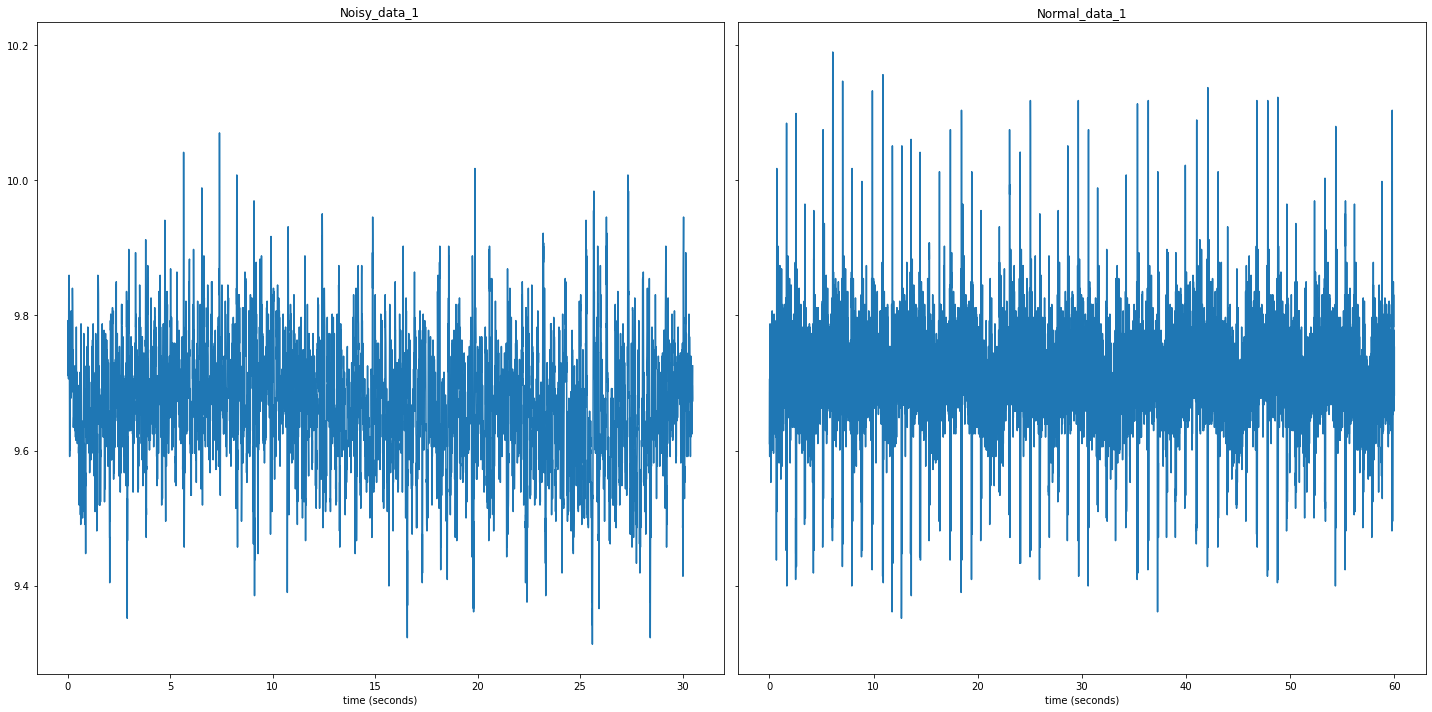

In [3]:
fs=200 #samp freq

fig, axes=plt.subplots(1, 2, figsize=(20, 10), sharey=True)

def time_seconds(data):
    fs=200
    time=np.linspace(0, len(data)/fs, len(data))
    return time
                     
y_data=[data['Noisy_data_1'], data['Normal_data_1']]
x_data=[time_seconds(data['Noisy_data_1']), time_seconds(data['Normal_data_1'])]

titles=['Noisy_data_1', 'Normal_data_1']
xlabel='time (seconds)'

for i in range(2):
    axes[i].set_title(titles[i])
    axes[i].set_xlabel(xlabel)
    axes[i].plot(x_data[i], y_data[i])
    plt.tight_layout()

# Data Segmentation 
* Here is a simple function to use for data segmentation
* Segment the Z-axis signals into 5-second segments
* The sampling frequency used to record these signals is 200 Hz.
* Store the segments and the accompanying labels

In [4]:
#code (provided)

def _slicing(sig, file_label, segment_length = 1000):
    
    """
    inputs:
    sig : input array to be segmented
    file_label : label to be applied to segmented signal
    segment_length : Length in samples of the segments produced from the input signal
    
    outputs:
    sig_sliced : a list of segments
    label : a list of corresponding labels for the segmented signal 
    
    """

    sig_sliced = []
    label = []
    
    # slicing 
    for i in np.arange(int(len(sig)/segment_length)):
        sig_sliced.append( sig[i*segment_length:(i+1)*segment_length] )
        label.append(file_label+'-Z-f{:02d}'.format(i))
        
    return (sig_sliced , label)

# Feature Extraction Function Creation
*  Define a function and name it “feature_extraction” in which you compute and return the features listed below
    * *Time Domain Features*:  mean, standard deviation, interquartile-range, median, peak-to-peak range, skewness, kurtosis, and root mean square. 
    * *Frequency Domain Features*: power spectral density (using welch function of scipy)
    
        * For power spectral density, Calculate the total power spectral density within frequency bins of 4 Hz steps. Discard the frequencies above 40 Hz. Get the power within each bin.
    
        Hint:
        
        Reference: https://docs.scipy.org/doc/scipy/reference/stats.html for skewness, kurtosis, interquartile-range(iqr)
        
        Reference: https://numpy.org/doc/stable/reference/routines.statistics.html for other time domain features
        
        Reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html for transforming to zero mean and unit variance



In [5]:
#code
import sklearn
def feature_extraction(sig, fs = 200):
    
    
    """
    inputs:
    sig : input array to extract features from
    fs : sampling frequency of input array

    
    outputs:
    feature_array: an array containing all the features extracted from the signal 
    """
    
    
    ########################################## statistical features - time domain

    mean=np.mean(sig)
    std=np.std(sig)
    median=np.median(sig)
    skewness=scipy.stats.skew(sig)
    interquartile_range=scipy.stats.iqr(sig)
    kurtosis=scipy.stats.kurtosis(sig)
    
    time_features=[mean, std, median, skewness, interquartile_range, kurtosis]
    
    
    ########################################## PSD 
    
    # transforming to zero mean and unit variance -- only do this when extracting PSD
    # Hint: transfromed_sig = function_for_scale(sig)
    
    transformed_sig = sklearn.preprocessing.scale(sig)
    frequencies , PSD = signal.welch(transformed_sig, fs)
    freqs_arr = np.arange(0,41,4)
    
    PSD_binned_sum = [] 
    
    for i in range(freqs_arr.shape[0]-1): 
        PSD_binned_sum.append (np.sum(PSD[np.where( (frequencies >= freqs_arr[i] ) &  ( frequencies < freqs_arr[i+1] ) )]) )
        
    PSD_binned_sum_pow=np.power(PSD_binned_sum, 2) #we should also get the power?
    
    frequency_features=[PSD_binned_sum_pow]
    
    
    return time_features, frequency_features
    


# Feature Extraction Application

* You must first segment your signals and then extract features from each segment. You could do it in the following way:



* Call the _slicing function to section all the z-axis data into 5-second segments
        Hint: Load each file in "dataFiles" with for-loop
* Use the feature extraction function you created and extract features from every segment that you have obtained.
* Store the labels and the features you extracted from each segment to numpy arrays. 
        Hint: Think of an easy way to extract the label "noisy" or "normal" from each file name
        str.split() could be used somehow in this case

In [6]:
features_segment_signals=[]
for i in range(len(paths)):
    segment_signal=_slicing(data[paths[i][8: -4]], paths[i][8: -4])
    for j in range(len(segment_signal[0])):
        feature_extracted=feature_extraction(segment_signal[0][j])
        features_segment_signals.append(( segment_signal[1][j], feature_extracted))

In [7]:
#an example: the first segment of the z-axis of the first file ('Noisy_data_1')
#the first array is referred to the time domain features, while the second one to the PSD

features_segment_signals[0][0]

'Noisy_data_1-Z-f00'

# Standardize Features
Hint:

    Use sklearn.preprocessing.scale() to standardize the features
    Reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html

In [8]:
standardize_time_features=[]
for i in range(len(paths)):
    standardize=sklearn.preprocessing.scale(features_segment_signals[i][1][0])
    standardize_time_features.append((features_segment_signals[i][0], standardize))

In [9]:
standardize_time_features[0]

('Noisy_data_1-Z-f00',
 array([ 1.41422892, -0.71132312,  1.41382786, -0.73326806, -0.7058076 ,
        -0.677658  ]))

# Principal Component Analysis
* Principal Component Analysis (PCA) is used to reduce the dimensionality of a data set consisting of many variables correlated with each other. This can then be used to visualize the data in a more practical way. 
* Compute the first and 2nd principal components
* Plot the two components on a scatter plot with the coloring done by label
* Are these features useful to seperate the two types of signals (noisy vs normal)?
* Describe your observations.
    
        Hint:
        my_pca=PCA(n_components=2)
        pca_out = my_pca.fit_transform(input)

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing as prep

X =df.values
##if the above doesn't work
#X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
X.shape
pca = PCA(n_components=2)
pca.fit(X)
PCA(n_components=2)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)


my_pca = PCA(n_components=2, svd_solver='full')
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
pca_out=my_pca.fit_transform(X)
PCA(n_components=2, svd_solver='full')
print(pca.explained_variance_ratio_)
print(pca.singular_values_)


plt.figure(figsize=(10, 7))
sns.scstterplot(x=pca_out[:, 0], y=Xpca_out[:, 1], s=70,
               hue=glob.target, palette=['red', 'blue'])

plt.title("Scatterplot Noisy and Normal signals", pad=15)
plt.xlabel("First principal component")
plt.xlabel("Second principal component")
plt.savefig("Scatterplot.jpg")

NameError: name 'df' is not defined

# Observations 

PCA identifies principal components, that are linear combinations of the original features. 

These components are extracted so that the first principal component encaptures maximum variance in the dataset and the second encaptures the remaining variance while being uncorrelated to the first.

PCA is used to denoise and to reduce dimensionality. In other words, it does not eliminate noise, but it can reduce noise.

It is well suitable to detect the spectral shape of small components even in noisy data.

Therefore, these features useful to seperate the two types of signals, which are noisy and normal.